# Toxicity Detection Model

Get live data with `get_comments.py` and transform Kaggle data set with `transform_train.py`

Get libraries by running `pip install -r requirements.txt`

This is a deep learning model.

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from wordcloud import STOPWORDS, wordcloud
import re
from fuzzywuzzy import fuzz, process

from tqdm import tqdm

# Load Dataset

In [5]:
df_train = pd.read_csv('./data/new_train.csv')
dataset = df_train # Let's use only one.

### Data Cleansing
<ul>
    <li>Removal of special characters</li>
    <li>Expanding contractions</li>
    <li>Lowering text</li>
    <li>Replacing Obfuscated Profane Words</li>
</ul>

In [ ]:
def decontracted(phrase):
    '''
    This function decontracts words like won't to will not
    '''

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [6]:
def removeNonPrintable(com):
    com = com.replace('\\r', ' ')
    com = com.replace('\\n', ' ')
    com = com.replace('\\t', ' ')
    com = com.replace('\\"', ' ')
    return com

In [22]:
def getUniqueWords(comments):
    unique_words = set()
    for comment in tqdm(comments):
        words = comment.split(" ")
        for word in words:
            if len(word) > 2:
                unique_words.add(word)
    
    return unique_words

In [23]:
def getProfaneWords():
    profane_words = []
    with open("./data/bad-words.txt","r") as f:
        for word in f:
            word = word.replace("\n","")
            profane_words.append(word)
    return profane_words
    

In [20]:
def createMappingDict(profane_words, unique_words):
    # mapping dictionary
    mapping_dict = dict()
    
    # looping through each profane word
    for profane in tqdm(profane_words):
        mapped_words = set()
        
        # looping through each word in vocab
        for word in unique_words:
            # mapping only if ratio > 80
            try:
                if fuzz.ratio(profane,word) > 80:
                    mapped_words.add(word)
            except:
                pass
                
        # list of all vocab words for given profane word
        mapping_dict[profane] = mapped_words
    
    return mapping_dict

In [27]:
def replaceWords(corpus, mapping_dict):
    processed_corpus = []

    for document in tqdm(corpus):

        # words = document.split()

        for mapped_word, v in mapping_dict.items():
            
            document = re.sub(r'\{word}\b'.format(word = v), mapped_word, document)

            # for target_word in v:

            #     for i, word in enumerate(words):
            #         if word == target_word:
            #             words[i] = mapped_word

        # document = " ".join(words)
        document = document.strip()

        processed_corpus.append(document)

    return processed_corpus



In [1]:
def final_processing(corpus):
    '''
    Function applies final processing steps post profane mapping such as removing special characters,
    punctuations etc.
    '''
    processed_comments = []
    processed_words = []
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
    "]+", re.UNICODE)


    # looping through each comment in corpus
    for comment in tqdm(corpus):
        comment = re.sub(emoj, '', comment)
        comment = re.sub(r'http\S+', '', comment)
        comment = re.sub("\B\#\w+", '', comment)
        comment = re.sub("\B\@\w+", '', comment)
        comment = re.sub('[^A-Za-z\s]+',"", comment) # retain only letters
        for word in comment.split():
            if len(word) >= 3:
                processed_words.append(word)
            
        comment = " ".join(processed_words)
        
        processed_comments.append(comment.strip())
    
    return processed_comments

In [ ]:
def cleanComments(comments):
    processed_comments = []
    for comment in comments:
        comment = decontracted(comment)
        comment = removeNonPrintable(comment)

        # Lower comment
        processed_comments.append(comment.lower().strip())
    
    profane_words = getProfaneWords()
    unique_words = getUniqueWords(processed_comments)
    profane_dict = createMappingDict(profane_words, unique_words)
    processed_comments = replaceWords(comments, profane_dict)
    return final_processing(processed_comments)

In [13]:
df_train.shape

(132291, 7)

In [14]:
df_train.head()

,Comment,Toxicity,Severe_Toxicity,Identity_Attack,Insult,Profanity,Threat
0,Explanation\nWhy the edits made under my usern...,0.129533,0.005232,0.009843,0.000779,0.000911,0.009409
1,D'aww! He matches this background colour I'm s...,0.022352,0.001590,0.010376,0.001265,0.001273,0.009809
2,"Hey man, I'm really not trying to edit war. It...",0.168278,0.004964,0.010698,0.004839,0.001866,0.009920
3,"""\nMore\nI can't make any real suggestions on ...",0.056532,0.002854,0.009954,0.001283,0.001134,0.009656
4,"You, sir, are my hero. Any chance you remember...",0.022491,0.002081,0.012285,0.004179,0.003558,0.011320


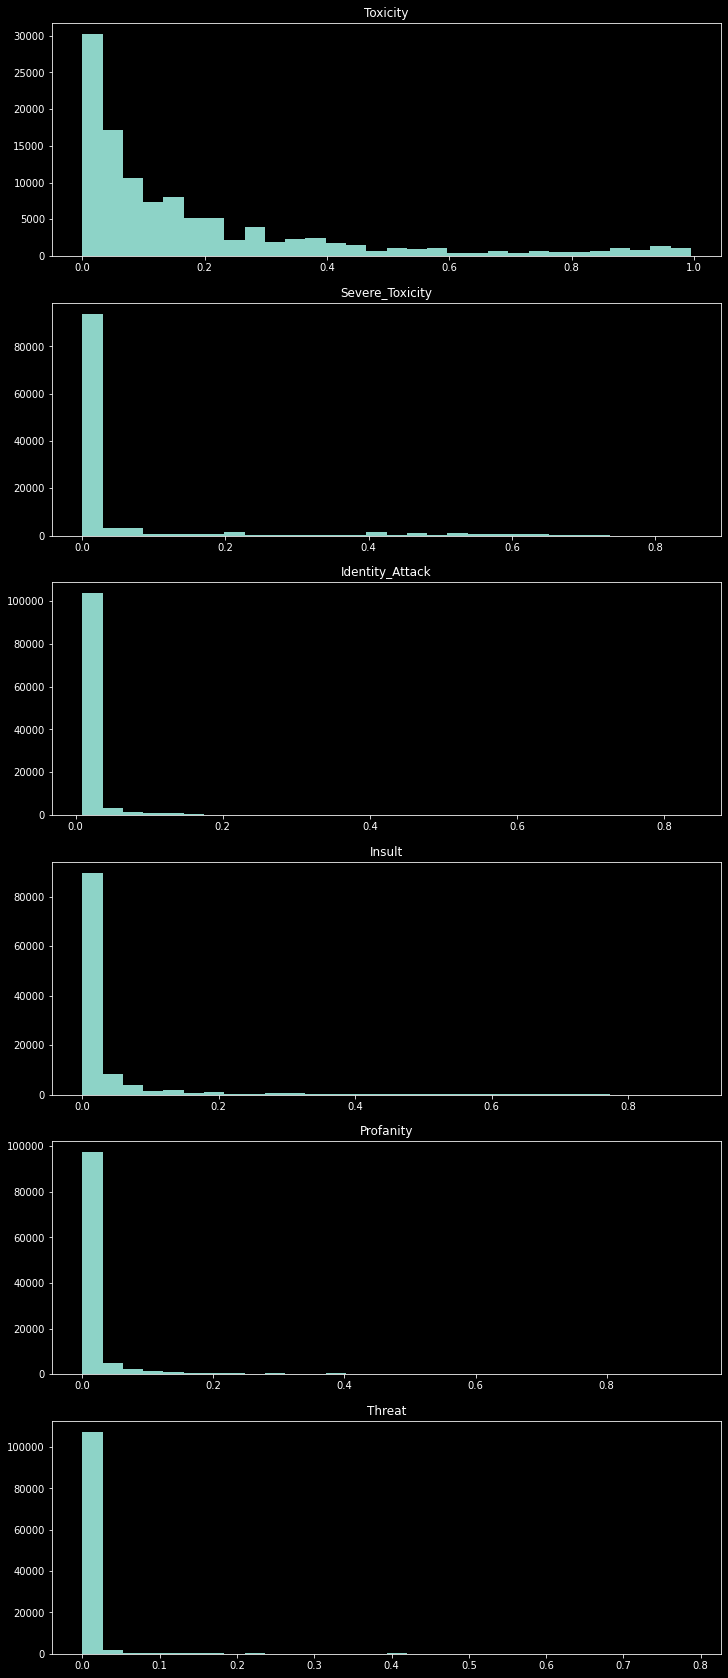

In [12]:
fig, axis = plt.subplots(len(df_train.columns)-1, 1, figsize = (12,30))
for i, col in enumerate(df_train.columns[1:]):
    counts, bins = np.histogram(df_train[col].values, bins = 30)
    axis[i].hist(bins[:-1], bins, weights=counts)
    axis[i].title.set_text(col)
plt.show()

(array([31050., 25108., 15563., 10200.,  6731.,  4560.,  3463.,  2589.,
         2020.,  1645.,  1448.,  1079.,   845.,   675.,   595.,   510.,
          419.,   321.,   343.,   241.,   234.,   178.,   158.,   148.,
          123.,   109.,   123.,   112.,    83.,   106.,    82.,    97.,
           77.,    83.,    78.,    77.,    62.,    75.,    69.,    61.,
           66.,    56.,    50.,    50.,    57.,    60.,    78.,    85.,
          100.,   149.]),
 array([   6.  ,  105.88,  205.76,  305.64,  405.52,  505.4 ,  605.28,
         705.16,  805.04,  904.92, 1004.8 , 1104.68, 1204.56, 1304.44,
        1404.32, 1504.2 , 1604.08, 1703.96, 1803.84, 1903.72, 2003.6 ,
        2103.48, 2203.36, 2303.24, 2403.12, 2503.  , 2602.88, 2702.76,
        2802.64, 2902.52, 3002.4 , 3102.28, 3202.16, 3302.04, 3401.92,
        3501.8 , 3601.68, 3701.56, 3801.44, 3901.32, 4001.2 , 4101.08,
        4200.96, 4300.84, 4400.72, 4500.6 , 4600.48, 4700.36, 4800.24,
        4900.12, 5000.  ]),
 <BarContainer ob

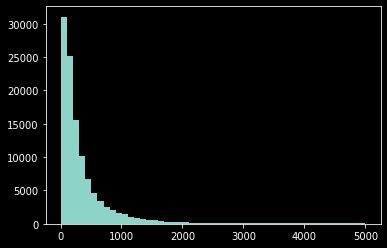

In [13]:
comments_lens = df_train.Comment.str.len()
counts, bins = np.histogram(comments_lens.values, bins = 50)
plt.hist(bins[:-1], bins, weights=counts)

In [14]:
for i in range(11):
    print(f'{i*10}th Percentile Value = {np.percentile(comments_lens, i*10)}')

0th Percentile Value = 6.0
10th Percentile Value = 47.0
20th Percentile Value = 79.0
30th Percentile Value = 114.0
40th Percentile Value = 155.0
50th Percentile Value = 205.0
60th Percentile Value = 274.0
70th Percentile Value = 368.0
80th Percentile Value = 529.0
90th Percentile Value = 893.0
100th Percentile Value = 5000.0


In [15]:
for i in range(11):
    print(f'{90+i}th Percentile Value = {np.percentile(comments_lens, 90 + i)}')

90th Percentile Value = 893.0
91th Percentile Value = 958.0
92th Percentile Value = 1031.0
93th Percentile Value = 1109.0
94th Percentile Value = 1215.0
95th Percentile Value = 1362.0
96th Percentile Value = 1541.0
97th Percentile Value = 1830.0
98th Percentile Value = 2351.0
99th Percentile Value = 3473.0
100th Percentile Value = 5000.0


In [ ]:
processed_comments = cleanComments(df_train.Comment.values[:500])

# Model Building

Turn dataset into list(list of tokens, scores x6))

In [ ]:
# Do above

In [ ]:
# Separate dataset into train and test. 9/1
train_dataset = []
test_dataset = []

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = keras.Sequential([
	encoder,
	layers.Embedding(
		input_dim = len(encoder.get_vocabulary()),
		output_dim = 64,
		# Use masking to handle the variable sequence lengths
		mask_zero = True
	),
	layers.Dropout(0.8),
	layers.Bidirectional(layers.LSTM(64)),
	layers.Dropout(0.6),
	layers.Dense(32, activation='relu'),
	layers.Dropout(0.5), # ?
	layers.Dense(6)
])

model.compile(loss = keras.losses.BinaryCrossentropy(from_logits = True),
			  optimizer = keras.optimizers.adam_v2.Adam(1e-4),
			  metrics = ['Toxicity', 'Severe_Toxicity', 'Identity_Attack', 'Insult', 'Profanity', 'Threat'])

In [ ]:
history = model.fit(train_dataset,
					epochs = 20,
					steps_per_epoch = 50,
					validation_data = test_dataset,
					validation_steps = 30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)